## Formulación en Programación Lineal en Julia

In [1]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [ ]:
using JuMP, HiGHS, Plots, DelimitedFiles, LinearAlgebra

#### Leer archivos TST en formato TSPLIB

In [ ]:
function read_tsp_file(filename)
    lines = readlines(filename)
    
    # Encontrar la sección de coordenadas
    coord_start = 0
    dimension = 0
    edge_type = ""
    
    for (i, line) in enumerate(lines)
        if startswith(line, "DIMENSION")
            dimension = parse(Int, split(line, ":")[2])
        elseif startswith(line, "EDGE_WEIGHT_TYPE")
            edge_type = strip(split(line, ":")[2])
        elseif startswith(line, "NODE_COORD_SECTION")
            coord_start = i
            break
        end
    end
    
    # Leer coordenadas
    coords = zeros(dimension, 2)
    for i in 1:dimension
        parts = split(lines[coord_start + i])
        coords[i, 1] = parse(Float64, parts[2])  # x
        coords[i, 2] = parse(Float64, parts[3])  # y
    end
    
    return coords, edge_type
end

#### Convertir coordenadas geográficas a distancias euclidianas

In [ ]:
function geo_to_euclidean(lat1, lon1, lat2, lon2)
    # Radio de la Tierra en km
    R = 6371.0
    
    # Convertir a radianes
    lat1_rad = deg2rad(lat1)
    lon1_rad = deg2rad(lon1)
    lat2_rad = deg2rad(lat2)
    lon2_rad = deg2rad(lon2)
    
    # Fórmula haversine
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = sin(dlat/2)^2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)^2
    c = 2 * atan(sqrt(a), sqrt(1-a))
    
    return R * c
end

#### Calcular matriz de distancias

In [ ]:
function calculate_distance_matrix(coords, edge_type)
    n = size(coords, 1)
    distances = zeros(n, n)
    
    for i in 1:n
        for j in 1:n
            if i != j
                if edge_type == "EUC_2D"
                    # Distancia euclidiana
                    distances[i, j] = sqrt((coords[i, 1] - coords[j, 1])^2 + 
                                         (coords[i, 2] - coords[j, 2])^2)
                elseif edge_type == "GEO"
                    # Distancia geográfica
                    distances[i, j] = geo_to_euclidean(coords[i, 1], coords[i, 2],
                                                      coords[j, 1], coords[j, 2])
                end
            end
        end
    end
    
    return distances
end

#### Solver según tamaño del problema

In [ ]:
function configure_solver(model, n_cities)
    set_silent(model)
    
    if n_cities <= 110
        # Para problemas pequeños: más precisión
        set_time_limit_sec(model, 300)      # 5 minutos
        set_attribute(model, "mip_rel_gap", 0.01)  # 1% gap
        println("Configuración: Problema pequeño ($n_cities ciudades) - 5 min, 1% gap")
    else
        # Para problemas grandes: más tiempo, menos precisión
        set_time_limit_sec(model, 7200)     # 120 minutos
        set_attribute(model, "mip_rel_gap", 0.15)  # 15% gap
        println("Configuración: Problema grande ($n_cities ciudades) - 120 min, 15% gap")
    end
end

#### Solver TSP usando formulación Miller-Tucker-Zemlin (MTZ)

In [ ]:
function solve_tsp_mtz(distances)
    n = size(distances, 1)
    
    # Crear modelo
    model = Model(HiGHS.Optimizer)
    
    # Configurar solver según tamaño
    configure_solver(model, n)
    
    # Variables de decisión
    @variable(model, x[1:n, 1:n], Bin)  # x[i,j] = 1 si vamos de i a j
    @variable(model, u[2:n] >= 0)       # Variables auxiliares para MTZ
    
    # Función objetivo: minimizar distancia total
    @objective(model, Min, sum(distances[i, j] * x[i, j] for i in 1:n, j in 1:n if i != j))
    
    # Restricciones: cada ciudad se visita exactamente una vez (salida)
    @constraint(model, [i in 1:n], sum(x[i, j] for j in 1:n if i != j) == 1)
    
    # Restricciones: cada ciudad se visita exactamente una vez (entrada)
    @constraint(model, [j in 1:n], sum(x[i, j] for i in 1:n if i != j) == 1)
    
    # Restricciones MTZ para eliminar subtours
    @constraint(model, [i in 2:n, j in 2:n; i != j], 
                u[i] - u[j] + n * x[i, j] <= n - 1)
    
    # Restricciones de dominio para u
    @constraint(model, [i in 2:n], u[i] <= n - 1)
    @constraint(model, [i in 2:n], u[i] >= 1)
    
    # Resolver
    println("Iniciando optimización...")
    start_time = time()
    optimize!(model)
    solve_time = time() - start_time
    
    # Extraer solución
    status = termination_status(model)
    
    if status == OPTIMAL || status == TIME_LIMIT
        # Verificar si hay solución disponible
        if has_values(model)
            objective_value = JuMP.objective_value(model)
            solution = JuMP.value.(x)
        else
            println("No se encontró solución factible en el tiempo límite")
            return Int[], Inf, status, solve_time
        end
        
        # Construir el tour
        tour = [1]
        current = 1
        while length(tour) < n
            for j in 1:n
                if j != current && solution[current, j] > 0.5
                    push!(tour, j)
                    current = j
                    break
                end
            end
        end
        
        println("Tiempo de solución: $(round(solve_time, digits=2)) segundos")
        
        if status == TIME_LIMIT
            gap = MOI.get(model, MOI.RelativeGap())
            println("Solución encontrada con gap: $(round(gap*100, digits=2))%")
        end
        
        return tour, objective_value, status, solve_time
    else
        println("No se pudo encontrar solución. Estado: $status")
        return Int[], Inf, status, solve_time
    end
end

#### Visualización de la solución

In [ ]:
function plot_tsp_solution(coords, tour, title_text, objective_value)
    # Preparar coordenadas del tour
    tour_coords_x = [coords[i, 1] for i in tour]
    push!(tour_coords_x, coords[tour[1], 1])  # Cerrar el ciclo
    
    tour_coords_y = [coords[i, 2] for i in tour]
    push!(tour_coords_y, coords[tour[1], 2])  # Cerrar el ciclo
    
    # Crear gráfico
    p = scatter(coords[:, 1], coords[:, 2], 
                label="Ciudades", 
                markersize=4, 
                color=:blue,
                title="$title_text\nDistancia óptima: $(round(objective_value, digits=2))")
    
    # Agregar el tour
    plot!(p, tour_coords_x, tour_coords_y, 
          label="Tour óptimo", 
          linewidth=2, 
          color=:red)
    
    # Marcar ciudad inicial
    scatter!(p, [coords[1, 1]], [coords[1, 2]], 
             label="Ciudad inicial", 
             markersize=8, 
             color=:green)
    
    return p
end

#### Resolver TSP desde archivo

In [ ]:
function solve_tsp_from_file(filename)
    println("Leyendo archivo: $filename")
    
    # Leer datos
    coords, edge_type = read_tsp_file(filename)
    n = size(coords, 1)
    
    println("Número de ciudades: $n")
    println("Tipo de distancia: $edge_type")
    
    # Calcular matriz de distancias
    println("Calculando matriz de distancias...")
    distances = calculate_distance_matrix(coords, edge_type)
    
    # Resolver TSP
    tour, objective_value, status, solve_time = solve_tsp_mtz(distances)
    
    println("Estado de la solución: $status")
    if !isempty(tour)
        println("Tour óptimo: $(tour[1:min(10, length(tour))])$(length(tour) > 10 ? "..." : "")")
        println("Distancia total: $(round(objective_value, digits=2))")
    end
    
    return tour, objective_value, status, solve_time
end

SOLUCIONADOR TSP CON PROGRAMACIÓN LINEAL
Usando formulación Miller-Tucker-Zemlin (MTZ)
Buscando archivos TSP...
Archivos encontrados: ./eil101.tsp, ./fibonacci_spiral_100.tsp, ./gr229.tsp

RESOLVIENDO: ./eil101.tsp
Leyendo archivo: ./eil101.tsp
Número de ciudades: 101
Tipo de distancia: EUC_2D
Calculando matriz de distancias...
Configuración: Problema pequeño (101 ciudades) - 5 min, 1% gap
Iniciando optimización...
Tiempo de solución: 154.78 segundos
Estado de la solución: OPTIMAL
Tour óptimo: [1, 50, 76, 77, 3, 79, 33, 81, 51, 9]...
Distancia total: 642.09

RESOLVIENDO: ./fibonacci_spiral_100.tsp
Leyendo archivo: ./fibonacci_spiral_100.tsp
Número de ciudades: 100
Tipo de distancia: EUC_2D
Calculando matriz de distancias...
Configuración: Problema pequeño (100 ciudades) - 5 min, 1% gap
Iniciando optimización...
Tiempo de solución: 19.33 segundos
Estado de la solución: OPTIMAL
Tour óptimo: [1, 6, 14, 22, 35, 56, 43, 30, 51, 38]...
Distancia total: 1756.35

RESOLVIENDO: ./gr229.tsp
Leyen

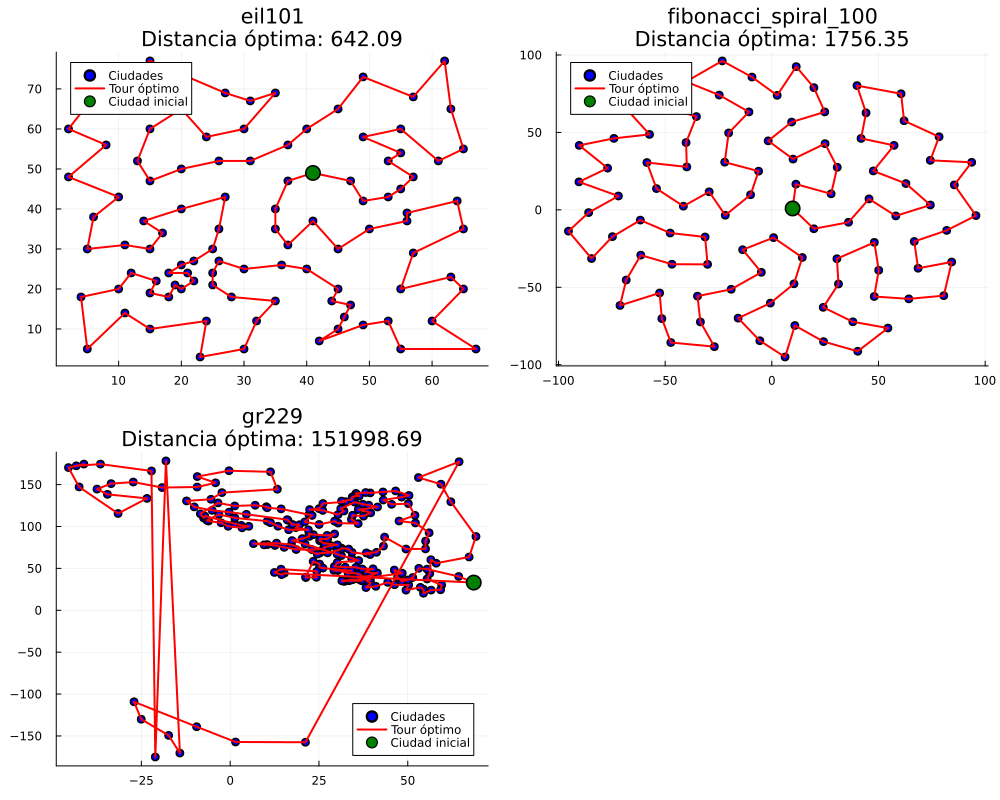

Dict{Any, Any} with 3 entries:
  "./eil101.tsp"               => (tour = [1, 50, 76, 77, 3, 79, 33, 81, 51, 9 …
  "./fibonacci_spiral_100.tsp" => (tour = [1, 6, 14, 22, 35, 56, 43, 30, 51, 38…
  "./gr229.tsp"                => (tour = [1, 2, 14, 15, 16, 17, 18, 20, 22, 21…

In [ ]:
function main()
    # Archivos TSP que tienes creados
    files = ["./eil101.tsp", "./fibonacci_spiral_100.tsp", "./gr229.tsp"]
    
    results = Dict()
    plots_array = []
    total_time = 0.0
    
    println("Buscando archivos TSP...")
    available_files = filter(isfile, files)
    
    if isempty(available_files)
        println("No se encontraron archivos TSP. Archivos esperados:")
        for file in files
            println("  - $file")
        end
        return results
    end
    
    println("Archivos encontrados: $(join(available_files, ", "))")
    
    for file in available_files
        println("\n" * "="^60)
        println("RESOLVIENDO: $file")
        println("="^60)
        
        try
            # Resolver TSP
            tour, obj_val, status, solve_time = solve_tsp_from_file(file)
            
            # Almacenar resultados
            results[file] = (
                tour=tour, 
                objective=obj_val, 
                status=status,
                solve_time=solve_time,
                n_cities=length(tour)
            )
            
            total_time += solve_time
            
            # Crear visualización si la solución es válida
            if !isempty(tour) && obj_val != Inf
                coords, _ = read_tsp_file(file)
                plot_title = replace(basename(file), ".tsp" => "")
                p = plot_tsp_solution(coords, tour, plot_title, obj_val)
                push!(plots_array, p)
            end
            
        catch e
            println("Error procesando $file: $e")
            results[file] = (error=e,)
        end
    end
    
    # Resumen de resultados
    println("\n" * "="^60)
    println("RESUMEN DE RESULTADOS")
    println("="^60)
    
    for (file, result) in results
        if haskey(result, :error)
            println("$file: ERROR - $(result.error)")
        else
            println("$file:")
            println("  Ciudades: $(result.n_cities)")
            println("  Distancia óptima: $(round(result.objective, digits=2))")
            println("  Estado: $(result.status)")
            println("  Tiempo: $(round(result.solve_time, digits=2)) segundos")
            println()
        end
    end
    
    println("Tiempo total de cómputo: $(round(total_time, digits=2)) segundos")
    
    # Mostrar gráficos
    if length(plots_array) > 0
        if length(plots_array) == 1
            display(plots_array[1])
        elseif length(plots_array) == 2
            combined_plot = plot(plots_array..., layout=(1, 2), size=(1000, 400))
            display(combined_plot)
        else
            combined_plot = plot(plots_array..., layout=(2, 2), size=(1000, 800))
            display(combined_plot)
        end
    end
    
    return results
end

# Ejecutar análisis
println("="^60)
println("SOLUCIONADOR TSP CON PROGRAMACIÓN LINEAL")
println("Usando formulación Miller-Tucker-Zemlin (MTZ)")
println("="^60)

results = main()